In [1]:
!pip install livelossplot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from livelossplot import PlotLossesKeras

In [3]:
#loading data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')


y=train["label"];
x = train.drop(labels=["label"],axis=1)

# reshaping data
y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

# Reshape data
x = x.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# One-Hot encoding
y = to_categorical(y, num_classes=10)



In [4]:
# Prepare training/validation sets
x_training, x_validation, y_training, y_validation = train_test_split(
    x,
    y,
    test_size=0.1,
    shuffle=True
)

In [5]:
model = Sequential()

model.add(Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding="Same",
    activation="relu",
    input_shape=(28,28,1)
    
))

model.add(Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding="Same",
    activation="relu",

    
))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.5))

model.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding="Same",
    activation="relu",

    
))

model.add(Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding="Same",
    activation="relu",

    
))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(8192,activation='relu'))
model.add(Dropout(.5))

model.add(Dense(2042,activation='relu'))
model.add(Dropout(.5))


model.add(Dense(10,activation="softmax"))


model.compile(optimizer=RMSprop(learning_rate=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
             loss="categorical_crossentropy",metrics=["accuracy"])


with open("model_summary.txt","w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))


2022-07-04 15:38:10.738108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 15:38:10.865694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 15:38:10.866721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 15:38:10.868827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [7]:
#data aumentaion
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)



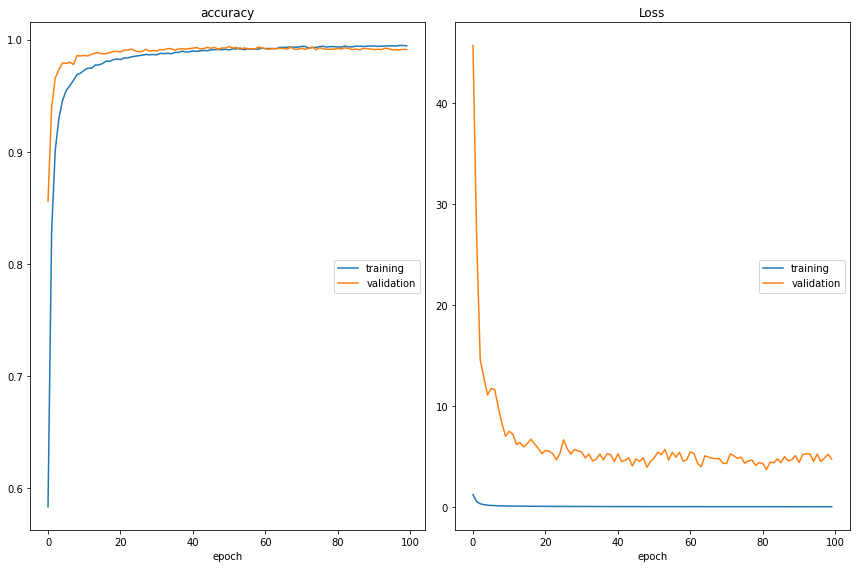

accuracy
	training         	 (min:    0.583, max:    0.995, cur:    0.994)
	validation       	 (min:    0.856, max:    0.994, cur:    0.991)
Loss
	training         	 (min:    0.016, max:    1.220, cur:    0.018)
	validation       	 (min:    3.692, max:   45.698, cur:    4.735)


In [8]:
# Training
history = model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=512),
                              epochs=100,
                              validation_data=(x_validation, y_validation),
                              verbose=1,
                              steps_per_epoch=x_training.shape[0] // 512,
                              callbacks=[PlotLossesKeras(),
                                         CSVLogger("training_logs.csv",
                                                   append=False,
                                                   separator=";")])
model.save_weights("model.h5")

In [9]:
# Testing
#predictions = model.predict_classes(test, verbose=1)
predict_x=model.predict(test)
classes_x=np.argmax(predict_x,axis=1)

pd.DataFrame({"ImageId":list(range(1,len(classes_x)+1)),
              "Label":classes_x}).to_csv("kaggle_submission.csv",
                                         index=False,
                                          header=True)

In [10]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'kaggle_submission.csv')

/kaggle/working/kaggle_submission.csv